## Семинар 4. Детекция аномалий

В ноутбуке — игрушечный датасет и реализованные методы 3σ, CUMSUM, STL-разложение + 3σ, Grubbs Test

Рекомендую к прочтению [статью](https://medium.com/booking-com-development/anomaly-detection-in-time-series-using-statistical-analysis-cc587b21d008) — отличный пример, как на стат методах можно посмотроить достаточно серьезный подход работы с аномалиями, автор из Booking.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import t
from statsmodels.tsa.seasonal import STL
import math

#### Визуализации

In [2]:
def get_3sigma_vis(df, x, metric, control=True):
    plt.figure(figsize=(12,6))

    plt.plot(df[x], df[metric], marker='o', label=metric)

    if control:
        plt.plot(df[x], df[f'{metric}_ucl'], label=f'{metric}_ucl')
        plt.plot(df[x], df[f'{metric}_lcl'], label=f'{metric}_lcl')
    
    plt.scatter(df[df[f'is_anomaly_{metric}']][x],
                df[df[f'is_anomaly_{metric}']][metric],
                color='red', s=60, zorder=3, label='anomaly')
    
    for x, y in zip(df[x], df[metric]):
        plt.text(x, y + 0.005, f'{y:.2f}', fontsize=8, ha='center', va='bottom')
    
    plt.title(f'{metric.capitalize()} Dynamics')
    plt.xlabel(x)
    plt.xticks(ticks=df.date, labels=df.date.astype(str), rotation=45)
    plt.ylabel(metric)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
def get_cusum_viz(df, x, metric, h=5):
    pos = df[f'{metric}_cusum_pos']
    neg = df[f'{metric}_cusum_neg']

    plt.figure(figsize=(12,6))
    
    plt.bar(df[x].astype(str), pos, color='blue', label='C+')
    plt.bar(df[x].astype(str), neg, color='salmon', label='C-')
    
    plt.axhline(h, color='grey',  label=f'H=+{h}')
    plt.axhline(0, color='grey')
    plt.axhline(-h, color='grey', label=f'H=-{h}')

    plt.title(f'CUSUM for {metric}')
    plt.xlabel('Date')
    plt.ylabel('CUSUM')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [4]:
def get_stl_viz(stl_result, metric):
    trend = stl_result.trend
    seasonal = stl_result.seasonal
    resid = stl_result.resid
    observed = stl_result.observed

    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    
    axes[0].plot(observed, label='Observed')
    axes[0].legend(loc='upper left')
    
    axes[1].plot(trend, color='orange', label='Trend')
    axes[1].legend(loc='upper left')
    
    axes[2].plot(seasonal, color='green', label='Seasonal')
    axes[2].legend(loc='upper left')
    
    axes[3].plot(resid, color='red', label='Residuals')
    axes[3].legend(loc='upper left')

    fig.suptitle(f'{metric} STL', fontsize=14)
    plt.tight_layout()
    plt.show()

#### Данные

Подневные конверсии в заполнение заявки на лендинге

In [5]:
df = pd.read_csv('data/seminar_4_landing.csv')

df.head()

,date,visitors,conversions,conversion_rate
0,2025-07-01,1468,80,0.054496
1,2025-07-02,1455,99,0.068041
2,2025-07-03,1491,91,0.061033
3,2025-07-04,1605,98,0.061059
4,2025-07-05,1541,83,0.053861


In [6]:
df.shape

(90, 4)

In [7]:
df['date'] = pd.to_datetime(df['date'])

<Axes: xlabel='date'>

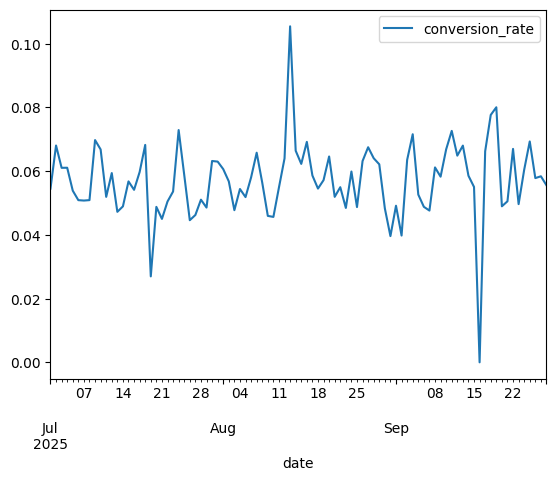

In [8]:
df.plot(x='date', y='conversion_rate')

### Метод 3σ

Попробуем применить самый базовый метод — метод 3σ. Мы будем имитировать онлайн проверку данных, поэтому для каждой даты нужно рассчитывать контрольные границы на данных n дней назад.

Берём последние $n$ значений:

$$
\mu_t = \frac{1}{n} \sum_{i=t-n}^{t-1} x_i, 
\quad 
\sigma_t = \sqrt{ \frac{1}{n-1} \sum_{i=t-n}^{t-1} (x_i - \mu_t)^2 }
$$
$$
UCL_t = \mu_t + 3\sigma_t, 
\quad 
LCL_t = \mu_t - 3\sigma_t
$$

In [9]:
def get_3_sigma_cl(df, metric, window=28, sigma=3):
    df[f'{metric}_mean'] = df[metric].shift(1).rolling(window=window, min_periods=window).mean()
    df[f'{metric}_ssd'] = df[metric].shift(1).rolling(window=window, min_periods=window).std(ddof=1)

    df[f'{metric}_ucl'] = df[f'{metric}_mean'] + sigma*df[f'{metric}_ssd']
    df[f'{metric}_lcl'] = df[f'{metric}_mean'] - sigma*df[f'{metric}_ssd']

    df[f'is_anomaly_{metric}'] = (df[metric] < df[f'{metric}_lcl']) | (df[metric] > df[f'{metric}_ucl'])

    return df

In [10]:
df_3sigma = get_3_sigma_cl(df, 'conversion_rate', window=14, sigma=3)

In [11]:
df_3sigma_august = df_3sigma[(df_3sigma['date'] >= pd.Timestamp(2025,8,1)) & (df_3sigma['date'] < pd.Timestamp(2025,9,1))]

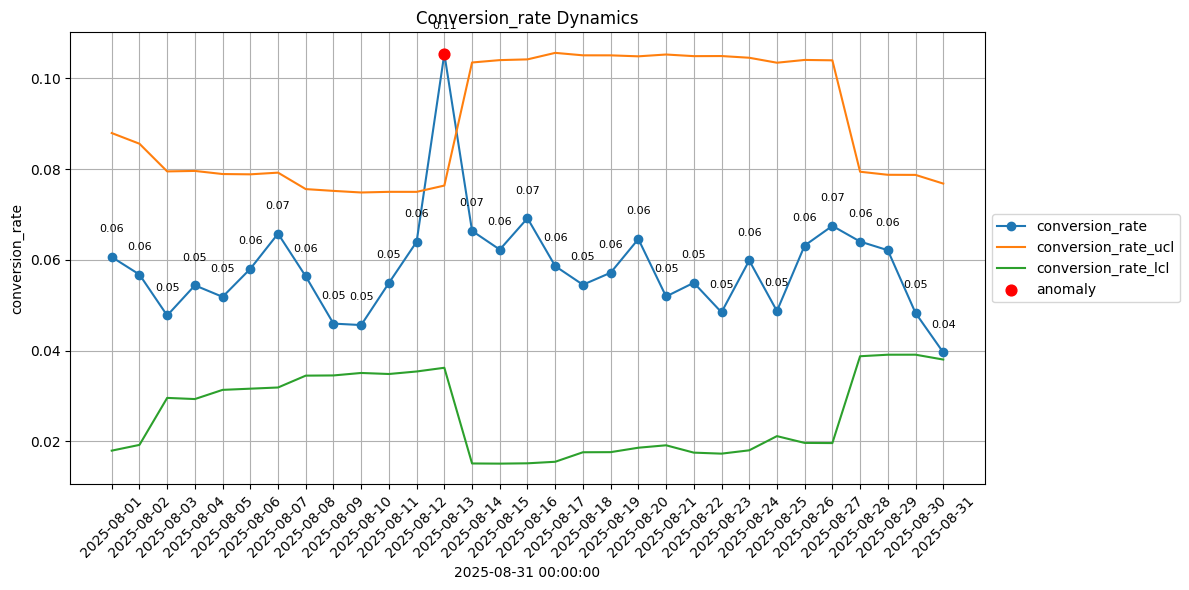

In [12]:
get_3sigma_vis(df_3sigma_august, 'date', 'conversion_rate')

### Метод CUMSUM

А может быть у нас есть участок данных, который ведет себя аномально? Используем CUSUM, чтобы ответить на этот вопрос.

Сначала переведём наблюдения в **z-оценки**:

$$
z_t = \frac{x_t - \mu_t}{\sigma_t},
$$

где:  
- $x_t$ — наблюдаемое значение в момент времени `t`,  
- $\mu_t$ — среднее в окне до момента `t`,  
- $\sigma_t$ — стандартное отклонение в окне до момента `t`.

Для положительных и отрицательных сдвигов рассчитываются две статистики:

$$
C_t^+ = \max \left\{ 0, \; C_{t-1}^+ + (z_t - k) \right\}
$$

$$
C_t^- = \max \left\{ 0, \; C_{t-1}^- + (-z_t - k) \right\}
$$

где:  
- $z_t$ — нормализованное отклонение,  
- $k$ — референcное значение (обычно половина минимального сдвига, который нужно обнаружить).

**Сигнал тревоги:**

$$
C_t^+ \geq h \quad \text{или} \quad C_t^- \geq h
$$

где $h$ — контрольный порог.

In [13]:
def get_cusum(df, metric, window=28, k=0.5, h=5):
    out = df.copy()
    
    out[f'{metric}_mean'] = out[metric].shift(1).rolling(window=window, min_periods=window).mean()
    out[f'{metric}_ssd']  = out[metric].shift(1).rolling(window=window, min_periods=window).std(ddof=1)

    z = (out[metric] - out[f'{metric}_mean']) / out[f'{metric}_ssd']

    pos, neg = [0.0], [0.0]
    for zi in z.fillna(0.0).values:
        pos.append(max(0.0, pos[-1] + zi - k))
        neg.append(min(0.0, neg[-1] + zi + k))
    out[f'{metric}_cusum_pos'] = pos[1:]
    out[f'{metric}_cusum_neg'] = neg[1:]

    out[f'is_anomaly_{metric}'] = (out[f'{metric}_cusum_pos'] > h) | (out[f'{metric}_cusum_neg'] < -h)

    return out

In [14]:
df_cumsum = get_cusum(df, 'conversion_rate', window=14, k=0.5, h=5)

In [15]:
df_cumsum_august = df_cumsum[(df_cumsum['date'] >= pd.Timestamp(2025,8,1)) & (df_cumsum['date'] < pd.Timestamp(2025,9,1))]

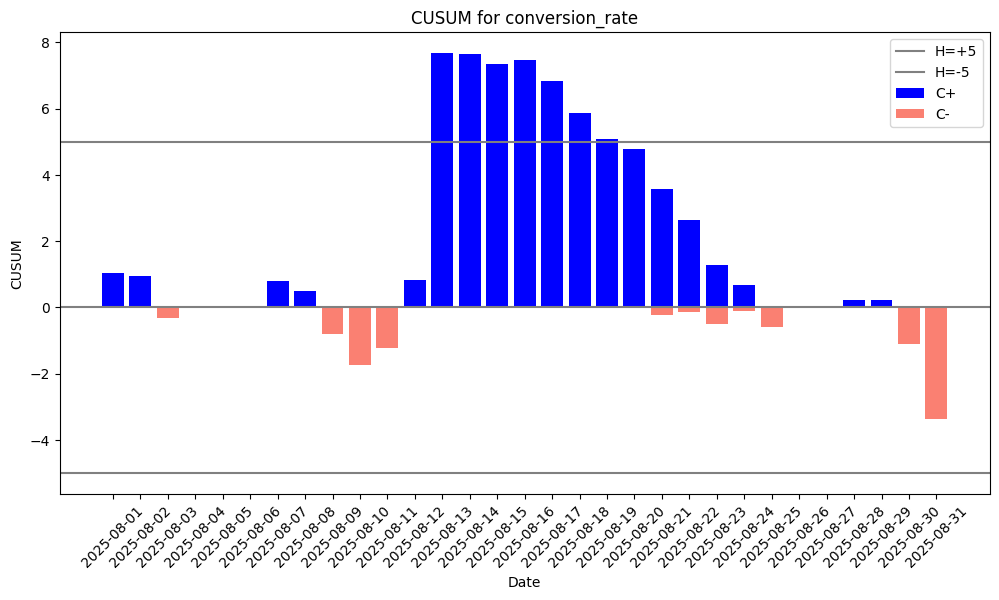

In [16]:
 get_cusum_viz(df_cumsum_august, 'date', 'conversion_rate')

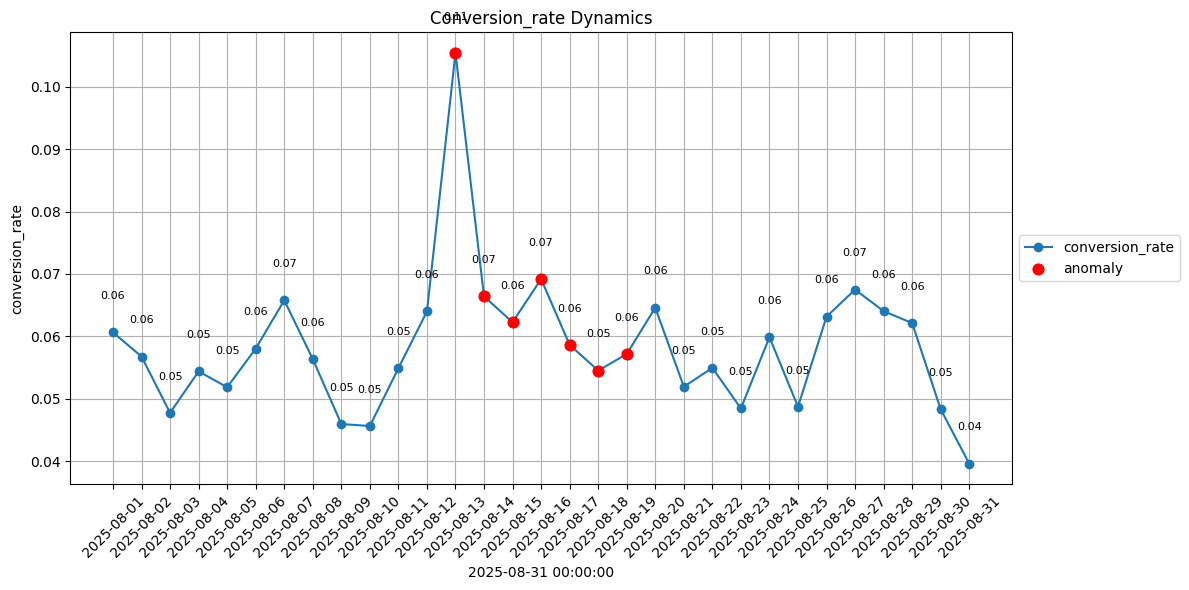

In [17]:
get_3sigma_vis(df_cumsum_august, 'date', 'conversion_rate', False)

### STL-разложение

Кажется, что метрика в динамике ведет себя достаточно волатильно. А что, если применить к ней STL-разложение?

In [18]:
def get_stl_results(df, x, metric, period=7):
    ts = df.set_index(x)[metric]
    stl = STL(ts, period=period)
    stl_result = stl.fit()

    return stl_result

In [19]:
stl_cr = get_stl_results(df, 'date', 'conversion_rate')

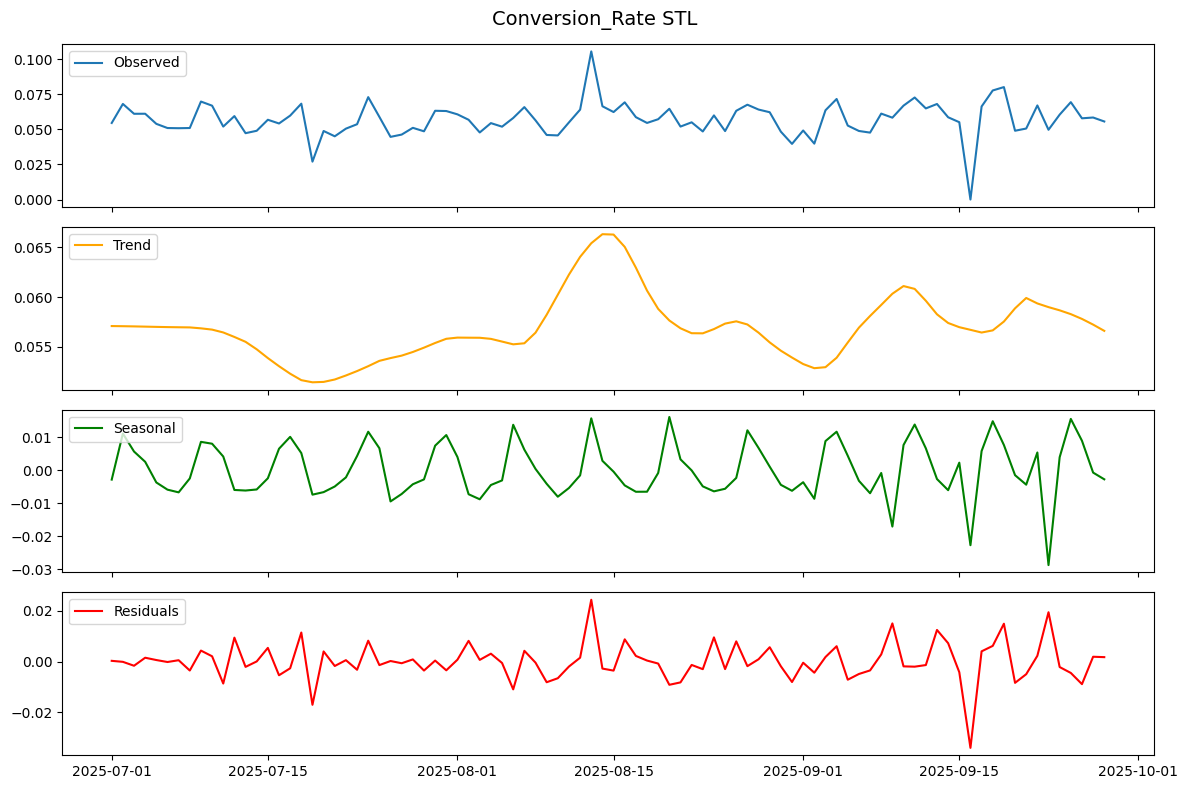

In [20]:
get_stl_viz(stl_cr, 'Conversion_Rate')

In [21]:
df['conversion_rate_resid'] = stl_cr.resid.values

In [22]:
def get_3_sigma_resid(df, metric, sigma=3):
    df[f'{metric}_mean'] = df[metric].mean()
    df[f'{metric}_ssd'] = df[metric].std(ddof=1)

    df[f'{metric}_ucl'] = df[f'{metric}_mean'] + sigma*df[f'{metric}_ssd']
    df[f'{metric}_lcl'] = df[f'{metric}_mean'] - sigma*df[f'{metric}_ssd']

    df[f'is_anomaly_{metric}'] = (df[metric] < df[f'{metric}_lcl']) | (df[metric] > df[f'{metric}_ucl'])

    return df

In [23]:
df_stl_august = df[(df['date'] >= pd.Timestamp(2025,8,1)) & (df['date'] < pd.Timestamp(2025,9,1))].reset_index(drop=True)

In [24]:
df_stl_3sigma_august = get_3_sigma_resid(df_stl_august, 'conversion_rate_resid', sigma=3)

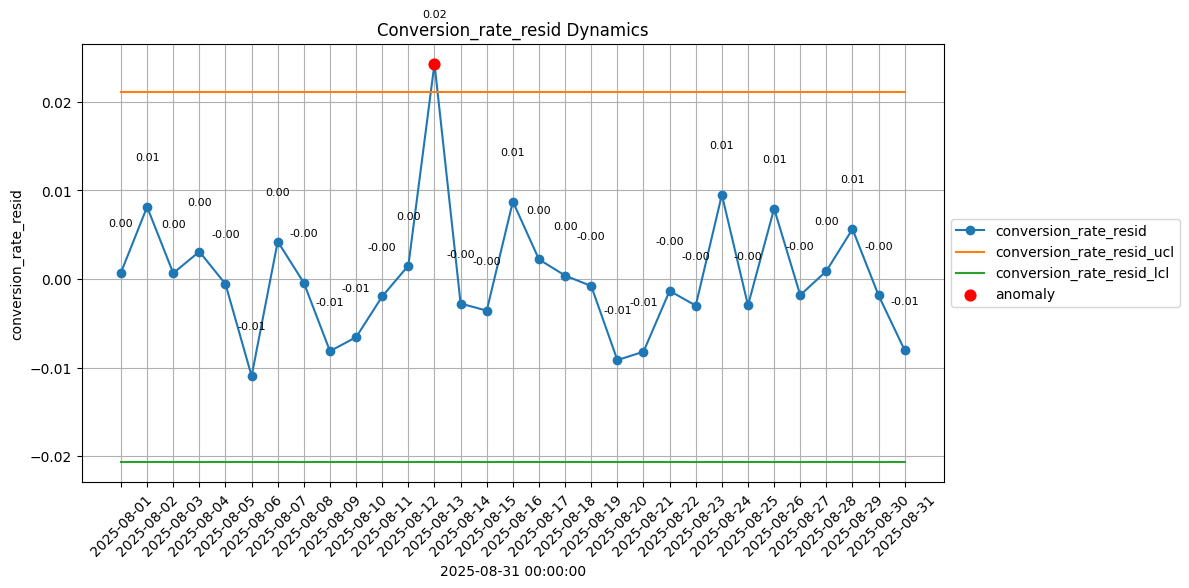

In [25]:
get_3sigma_vis(df_stl_3sigma_august, 'date', 'conversion_rate_resid')

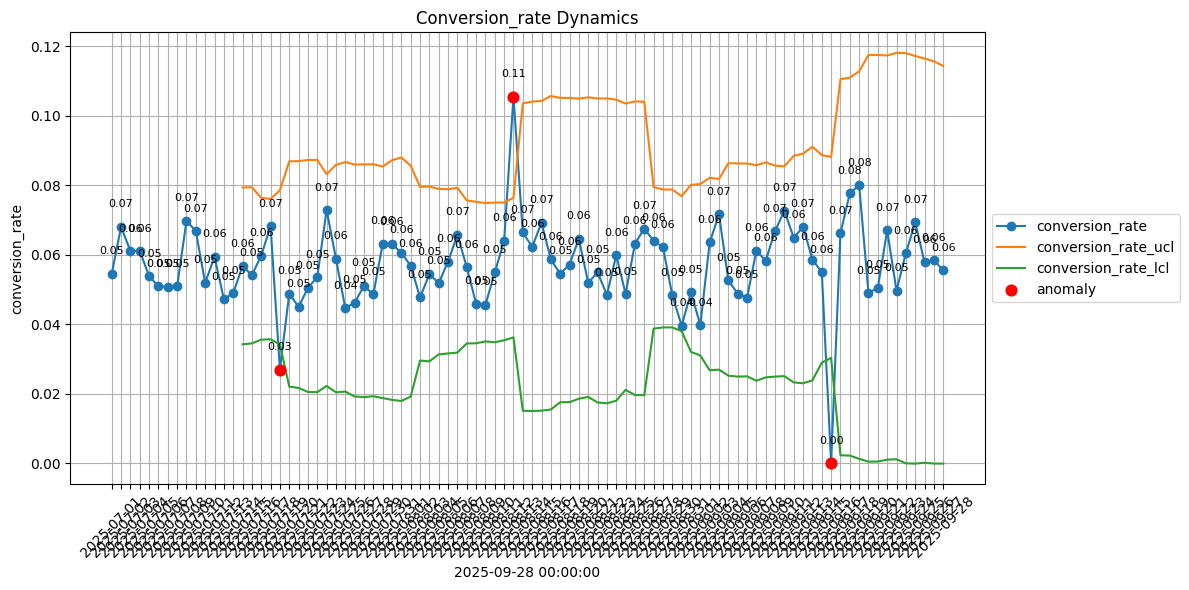

In [44]:
get_3sigma_vis(df_3sigma, 'date', 'conversion_rate')

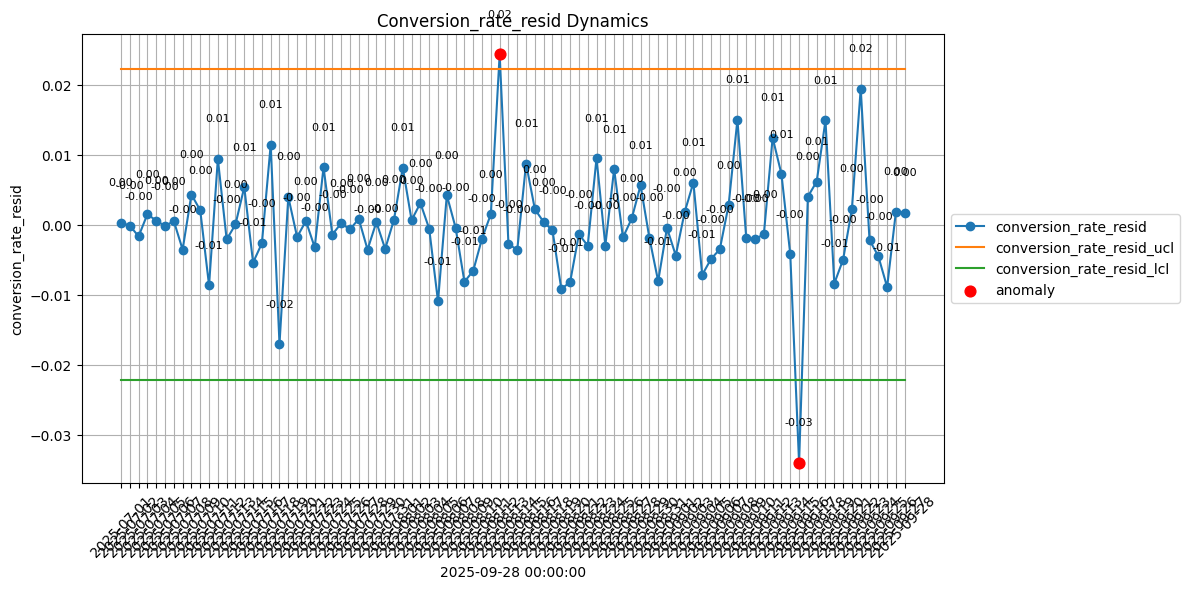

In [45]:
get_3sigma_vis(get_3_sigma_resid(df, 'conversion_rate_resid', sigma=3), 'date', 'conversion_rate_resid')

### Grubbs Test

Статистика:
$$
G = \max_i \frac{|x_i - \bar{x}|}{s}
$$

где  
- $x_i$ — наблюдение,  
- $\bar{x}$ — среднее всех наблюдений,  
- $s$ — стандартное отклонение.  

Сравнивается с критическим значением $G_{crit}$ (из t-распределения).

**Критическое значение:**

$$
G_{crit} = \frac{(n-1)}{\sqrt{n}} \cdot 
\sqrt{ \frac{t_{\alpha/(2n),\, n-2}^2}{n-2+t_{\alpha/(2n),\, n-2}^2} }
$$

где  
- $n$ — размер выборки,  
- $t_{\alpha/(2n),\, n-2}$ — квантиль t-распределения с $(n-2)$ степенями свободы,  
- $\alpha$ — уровень значимости (обычно $0.05$).

**Правило:**

Если 
$$
G > G_{crit}
$$

самая экстремальная точка признаётся выбросом.

In [29]:
def grubbs_test(df, metric, alpha=0.05, side='two-sided'):
    x = df[metric].dropna().astype(float)
    N = x.size
    
    mean = x.mean()
    s = x.std(ddof=1)
    
    if side == 'two-sided':
        diff = (x - mean).abs()
        idx = diff.idxmax()
        G = diff.loc[idx] / s
        p = 1 - alpha/(2*N)
    elif side == 'high':
        idx = x.idxmax()
        G = (x.loc[idx] - mean) / s
        p = 1 - alpha/(N)
    elif side == 'low':
        idx = x.idxmin()
        G = (mean - x.loc[idx]) / s
        p = 1 - alpha/(N)
        
    tcrit = t.ppf(p, df=N-2)
    Gcrit = ((N - 1)/np.sqrt(N)) * np.sqrt((tcrit**2) / (N - 2 + tcrit**2))

    is_outlier = G >= Gcrit

    return {
        'mean': float(mean),
        'std': float(s),
        'G': float(G),
        'Gcrit': float(Gcrit),
        'is_outlier': bool(is_outlier),
        'outlier_value': float(x.loc[idx]),
        'date': df['date'][idx]
    }

In [30]:
df_stl_august = df[(df['date'] >= pd.Timestamp(2025,8,1)) & (df['date'] < pd.Timestamp(2025,9,1))].reset_index(drop=True)

In [31]:
grubbs_test(df_stl_august, 'conversion_rate', alpha=0.05, side='two-sided')

{'mean': 0.0583497917744409,
 'std': 0.011428564984613672,
 'G': 4.120001305717786,
 'Gcrit': 2.9235705613300507,
 'is_outlier': True,
 'outlier_value': 0.1054354944335298,
 'date': Timestamp('2025-08-13 00:00:00')}